## Sine Coulomb Matrix Feature Engineering:
### density representation of eigenvalues and PCA-based datasets
This notebook generates 3 datasets:

0. SSDs, (smoothed) density representations of the eigenspectra of the sine Coulomb matrices
1. the top principal components of the SSDs, with PCA restricted to the MOFs in the final stoich45 training datasets that Simran generated
2. the top principal components of the SSDs, with PCA done over all MOFs in the full training set (train_hse06.csv)

Code to generate the third dataset is included here for completeness, but it should only be used if our final model excludes features from stoich45.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### load 'raw' datasets

In [3]:
# the hse06 training dataset
df_hse06_training = pd.read_csv('../data/datasets_main/train_hse06.csv', sep=',')

# sine Coulomb matrix eigenvalue list dataset
df_scm_eigs = pd.read_csv('../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_fingerprints.csv', sep=',')

# Simran's stoich45-based datasets 
df_stoich45PCA = pd.read_csv('../data/datasets_main/Stoich45_PCA_dataset.csv', sep=',')
df_stoich45Selected = pd.read_csv('../data/datasets_main/Stoich45_FeatureSelected_dataset.csv', sep=',')

### dataset 0: smoothed spectral density (SSD) representation of the sine Coulomb matrix eigenvalues
Generate the SSD representation for all MOFs in the QMOF database. The resulting dataset (sine_matrix_SSDs.csv) can be thought over as an alternative 'fingerprint' (in place of sine_matrix_fingerprints.csv). Comments:
- The SSDs are computed over $x$, the locations of the eigenvalues on a log-scale, so there are actually two densities: one for positive eigenvalues and one for negative. This subltely is however not important for our next steps, since the two densities will together be passed into PCA to generate the  features to be used for modeling.
- This uses a Gaussian kernel to smooth the spectral density, with a 'standard deviation' / smoothing scale in $x$ of 0.1. The value of this scale is potentially a hyper-parameter. But, given how long it takes to generate the SSDs, we may want to avoid tuning it.
- The SSDs are discretized in intervals in $x$ of 0.02, so as to 'resolve' the scale of 0.1. There is a discretization error, since the Guassian kernels are simply sampled at discrete values of $x$. Ideally, one would instead use the integral of the Guassian over the discrete intervals. The error is, however, small: the maximum absolute error for the contribution of a single eigenvalue is $0.00166$, which occurs if the ($\log_{10}$ of the absolute value of the) eigenvalue coincides with a discrete value of $x$. (The contribution in that case should be $1.00166$, instead of $1$ as computed below.) So the extra computational expense of the more accurate calculation seems unnecessary and avoidable.
- The densities are not normalized, since the computation below does not include the Guassian prefactor of $\frac{1}{\sqrt{2\pi\sigma^2}}$ or account for the discretization interval. But (up to the discretization error) the sum of the density values is proportional to the number of atoms in the MOF's unit cell. The constant of proportionality, which depends on the Guassian prefactor and discretization interval is common across all MOFs. So, again, this subltely is irrelevant once PCA is used to generate features.

In [ ]:
num_MOFs = df_scm_eigs.shape[0]
xRange = np.arange(-5,5.02,.02)

#empty array to store density values
ssdPositive_array = np.empty((num_MOFs, len(xRange)))
ssdNegative_array = np.empty((num_MOFs, len(xRange)))

# iterate over rows
for (i, row) in df_scm_eigs.iloc[0:num_MOFs].iterrows():
    if i % 100 == 0:
        print('MOF ', i, ' out of ', num_MOFs)
    
    eigs = row[1:].astype(np.float64)
    ssdPositive_array[i] = np.round(
        [
            np.sum(np.exp(-((x - np.log10(eigs[eigs > 0]))/0.1)**2 / 2)) # add contributions from each positive eigenvalue to density at x
            for x in xRange
        ],
        decimals = 6 #round each density value to the nearest 10^-6
    )
    
    ssdNegative_array[i] = np.round(
        [
            np.sum(np.exp(-((x - np.log10(-eigs[eigs < 0]))/0.1)**2 / 2)) # add contribution from each negative eigenvalue to density at x 
            for x in xRange
        ],
        decimals = 6 #round each density value to the nearest 10^-6
    )

# convert arrays to data frames and label columns with x values
df_ssdPositive = pd.DataFrame(data = ssdPositive_array, columns = ['x = ' + ('%0.2f' % x) + ' (eigs > 0)' for x in xRange])
df_ssdNegative = pd.DataFrame(data = ssdNegative_array, columns = ['x = ' + ('%0.2f' % x) + ' (eigs < 0)' for x in xRange])

# concatenate SSDPositive and SSDNegative dataframes with the MOF id column
df_ssd = pd.concat((df_scm_eigs.iloc[0:num_MOFs][['MOF']], df_ssdPositive, df_ssdNegative), axis = 1)

# save resulting dataframe
df_ssd.to_csv('../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_SSDs.csv', sep=',', index=False)

Since sine_matrix_SSDs.csv was already generated, just import the SSDs, instead of re-running the above code:

In [5]:
df_ssd = pd.read_csv('../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/sine_matrix_SSDs.csv', sep=',')

### dataset 1: PCA of SSDs over stoich45 training MOFs
Restrict the SSDs to the MOFs included in the final stoic45 training sets. And normalize so that the sum of SSDs for each MOF is 1. Note: I am not using the Standard Scalar before PCA. That tends to amplify the small variations in the eigenspecturm, which may not be important. And, without scaling, fewer principal components are needed to explain 90% of the variance.

In [51]:
# merge to restrict
df_ssd_stoich45_training = df_stoich45PCA[['MOF']].merge(df_ssd)

# normalize
ssd_cols = df_ssd_stoich45_training.columns[1:]
df_ssd_stoich45_training[ssd_cols] = df_ssd_stoich45_training[ssd_cols].div(df_ssd_stoich45_training[ssd_cols].sum(axis=1), axis=0)

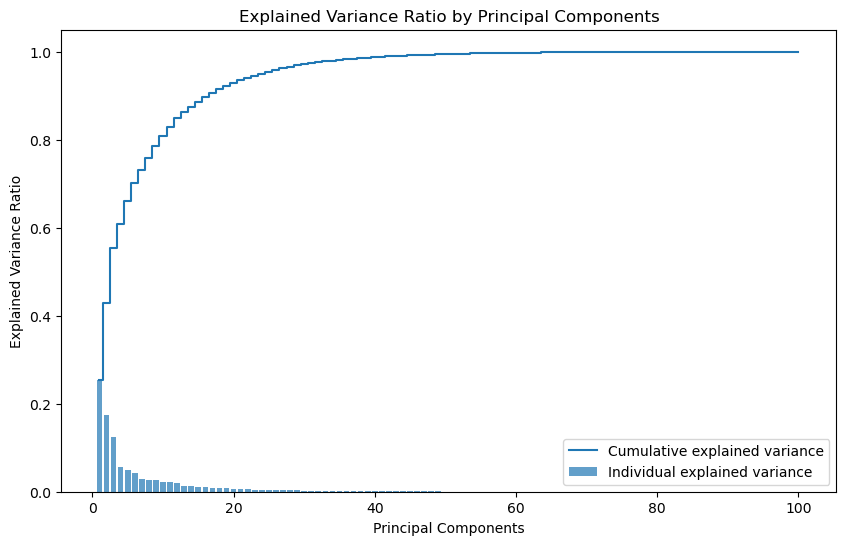

In [67]:
# Perform PCA
pca = PCA(n_components=100)
ssd_pca = pca.fit_transform(df_ssd_stoich45_training[ssd_cols])

# Create a DataFrame with the PCA results
df_ssd_pca = pd.DataFrame(data=ssd_pca, columns=[f'sineCM PC {i+1}' for i in range(n)])

# Plot the explained variance ratio for each principal component and the cumulative ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.show()

In [69]:
n_components = [i for (i, cev) in enumerate(np.cumsum(pca.explained_variance_ratio_)) if cev > .9][0] + 1
print(n_components, 'components are needed to explain at least 90% of the variance.')
np.cumsum(pca.explained_variance_ratio_)[n_components-2:n_components+1]

17 components are needed to explain at least 90% of the variance.


array([0.89678721, 0.90580987, 0.91477624])

In [66]:
# save the 17 principal components along with MOF id and bandgap
df_ssd_pca_final = df_ssd_pca[[f'sineCM PC {i+1}' for i in range(n_components)]]
df_ssd_pca_final['outputs.hse06.bandgap'] = df_stoich45PCA['outputs.hse06.bandgap']
df_ssd_pca_final['MOF'] = df_stoich45PCA['MOF']
df_ssd_pca_final.to_csv('../data/datasets_main/SCM_PCA_trainingStoich45_dataset.csv', index=False)

/var/folders/wv/fr4yw5nn3qzctb27hyfl7fzh0000gn/T/ipykernel_99371/3864456013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssd_pca_final['outputs.hse06.bandgap'] = df_stoich45PCA['outputs.hse06.bandgap']
/var/folders/wv/fr4yw5nn3qzctb27hyfl7fzh0000gn/T/ipykernel_99371/3864456013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssd_pca_final['MOF'] = df_stoich45PCA['MOF']


### dataset 2: PCA of SSDs over all training MOFs
Use SSDs from all the MOFs in the full training set. Again normalize so that the sum of SSDs for each MOF is 1.

In [46]:
# merge to restrict
df_ssd_all_training = df_hse06_training[['qmof_id']].merge(df_ssd, left_on='qmof_id', right_on='MOF', how='left').drop(columns=['qmof_id'])

# normalize
ssd_cols = df_ssd_all_training.columns[1:]
df_ssd_all_training[ssd_cols] = df_ssd_all_training[ssd_cols].div(df_ssd_all_training[ssd_cols].sum(axis=1), axis=0)

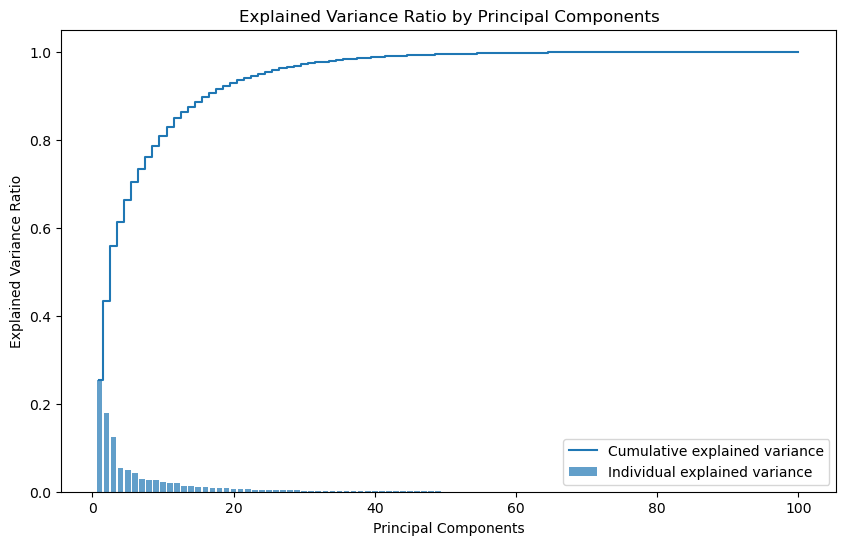

In [47]:
# Perform PCA
pca = PCA(n_components=100)
ssd_pca = pca.fit_transform(df_ssd_all_training[ssd_cols])

# Create a DataFrame with the PCA results
df_ssd_pca = pd.DataFrame(data=ssd_pca, columns=[f'sineCM PC {i+1}' for i in range(n)])

# Plot the explained variance ratio for each principal component and the cumulative ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.show()

In [48]:
n_components = [i for (i, cev) in enumerate(np.cumsum(pca.explained_variance_ratio_)) if cev > .9][0] + 1
print(n_components, 'components are needed to explain at least 90% of the variance.')
np.cumsum(pca.explained_variance_ratio_)[n_components-2:n_components+1]

17 components are needed to explain at least 90% of the variance.


array([0.89674346, 0.90565527, 0.91444411])

In [49]:
# save the 17 principal components along with MOF id and bandgap
df_ssd_pca_final = df_ssd_pca[[f'sineCM PC {i+1}' for i in range(n_components)]]
df_ssd_pca_final['outputs.hse06.bandgap'] = df_hse06_training['outputs.hse06.bandgap']
df_ssd_pca_final['MOF'] = df_hse06_training['qmof_id']
df_ssd_pca_final.to_csv('../data/datasets_main/SCM_PCA_trainingAll_dataset.csv', index=False)

/var/folders/wv/fr4yw5nn3qzctb27hyfl7fzh0000gn/T/ipykernel_99371/3305953023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssd_pca_final['outputs.hse06.bandgap'] = df_hse06_training['outputs.hse06.bandgap']
/var/folders/wv/fr4yw5nn3qzctb27hyfl7fzh0000gn/T/ipykernel_99371/3305953023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssd_pca_final['MOF'] = df_hse06_training['qmof_id']
